# Initial Model TFLite

This is the test notebook for the inital model that we will be using for the project.
There will be a lot of changes to this model as we go on, and we will be using this notebook to test those changes.


## Setup Environment


Mac Environment Setup:

1. Create a new virtual environment with Python 3.10. Do not use the setup_env.sh script.

- `python3.10 -m venv .venv`
- `source .venv/bin/activate`
- `pip install -r requirements.txt`

2. Verify that TensorFlow is working with the GPU.

- Check the output of the following cell. You should see something like:
  - TensorFlow version: 2.16.2
  - Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
  - Result: tf.Tensor([5. 7. 9.], shape=(3,), dtype=float32)
  - Metal device set to: Apple M1 Pro
  - systemMemory: 16.00 GB
  - maxCacheSize: 5.33 GB


In [1]:
# Initial Model TFLite

## Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras.callbacks import TensorBoard
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import Video
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


import os
import json
import shutil
import glob
import random
import math
import pydot
import graphviz
import datetime

# Verify TensorFlow installation
print(f"TensorFlow version: {tf.__version__}")

# Enable verbose logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"

# Check GPU devices
gpus = tf.config.list_physical_devices("GPU")
print("Available GPUs:", gpus)

# Perform a computation
with tf.device("/GPU:0"):
    a = tf.constant([1.0, 2.0, 3.0])
    b = tf.constant([4.0, 5.0, 6.0])
    c = a + b
    print("Result:", c)


# The first time this cell is run, make sure that you see:
# Metal device set to: Apple M[GPU]

TensorFlow version: 2.16.2
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Result: tf.Tensor([5. 7. 9.], shape=(3,), dtype=float32)


2024-12-07 12:22:40.046855: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-07 12:22:40.046892: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-07 12:22:40.046900: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-07 12:22:40.046921: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-07 12:22:40.046937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
# Setup directories and filenames
NOTEBOOK_TAG = "initial_model"
MODEL_NAME = "rep_mate.keras"

MODELS_DIR = NOTEBOOK_TAG + "/models"
DATASET_DIR = NOTEBOOK_TAG + "/dataset"
CHKPT_DIR = NOTEBOOK_TAG + "/checkpoints"
LOG_DIR = NOTEBOOK_TAG + "/logs"
PLOT_DIR = "plots"
ANIM_DIR = "anim"

# Create base directories with parents
for directory in [MODELS_DIR, DATASET_DIR, CHKPT_DIR, PLOT_DIR]:
    os.makedirs(directory, exist_ok=True)

# Define model filenames
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR, MODEL_NAME)
FLOAT_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, MODEL_NAME + "_float.tfl")
QUANTIZED_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, MODEL_NAME + ".tfl")
TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, MODEL_NAME + ".cc")

# Define dataset directories
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "validation")
TEST_DIR = os.path.join(DATASET_DIR, "test")

# Create dataset subdirectories
for directory in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(directory, exist_ok=True)

In [3]:
CLEAR_DATA = True

# Directories to clean up
DIRS = [
    MODELS_DIR,
    DATASET_DIR,
    CHKPT_DIR,
    TRAIN_DIR,
    VAL_DIR,
    TEST_DIR,
    LOG_DIR,
    CHKPT_DIR,
]


def remove_files_in_directory(directory):
    if not os.path.exists(directory):
        return

    for root, dirs, files in os.walk(directory, topdown=False):
        for name in files:
            file_path = os.path.join(root, name)
            try:
                os.unlink(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")


def cleanup_all_files(dirs=DIRS):
    print(
        "WARNING: This will delete all files in the following directories and their subdirectories:"
    )
    for dir in dirs:
        if os.path.exists(dir):
            total_files = sum([len(files) for _, _, files in os.walk(dir)])
            print(f"  - {dir} ({total_files} files)")

    confirmation = input("\nType 'YES' to confirm deletion: ")

    if confirmation == "YES":
        for directory in dirs:
            if os.path.exists(directory):
                remove_files_in_directory(directory)
                print(f"Removed files from: {directory}")
        print("\nAll files have been removed while preserving directory structure.")
    else:
        print("\nOperation cancelled.")


if CLEAR_DATA:
    cleanup_all_files(DIRS)

  - initial_model/models (0 files)
  - initial_model/dataset (299 files)
  - initial_model/checkpoints (0 files)
  - initial_model/dataset/train (0 files)
  - initial_model/dataset/validation (0 files)
  - initial_model/dataset/test (0 files)
  - initial_model/logs (0 files)
  - initial_model/checkpoints (0 files)
Removed files from: initial_model/models
Removed files from: initial_model/dataset
Removed files from: initial_model/checkpoints
Removed files from: initial_model/dataset/train
Removed files from: initial_model/dataset/validation
Removed files from: initial_model/dataset/test
Removed files from: initial_model/logs
Removed files from: initial_model/checkpoints

All files have been removed while preserving directory structure.


## Import Dataset


In [4]:
# Copy all files from data into notebook dataset directory
!cp -r ../data/* {DATASET_DIR}

# Get all the files in the dataset directory
DATASET_FILES = glob.glob(os.path.join(DATASET_DIR, "*", "*", "*"))

# Print the number of files in the dataset
print(f"Number of files in dataset: {len(DATASET_FILES)}")


Number of files in dataset: 298


In [5]:
# Python list to hold the dataset
DATASET = []

# Read each file and append to the dataset, add filename to the file data
for f in DATASET_FILES:
    with open(f, "r") as file:
        f_c = file.read()
    f_d = json.loads(f_c)
    f_d["filename"] = f
    DATASET.append(f_d)

print(f"Number of files in dataset: {len(DATASET)}")

Number of files in dataset: 298


## Visualize Dataset


In [6]:
def set_matplotlib_backend(backend="inline"):
    """
    Switch matplotlib backend between 'inline' and 'notebook'
    Args:
        backend (str): Either 'inline' (static plots) or 'notebook' (interactive/animations)
    """
    from IPython import get_ipython

    ipython = get_ipython()
    ipython.run_line_magic("matplotlib", backend)

In [7]:
LIFT_NAMES = {"dC": "Dumbbell Curl", "bP": "Bench Press", "dF": "Dumbbell Fly"}
LIFT_CLASSES = {
    "p_f": "Perfect Form",
    "l_i": "Lift Instability",
    "p_m": "Partial Motion",
    "o_a": "Off-Axis",
    "s_w": "Swinging Weight",
    "n_l": "No Lift",
}

# Feature Names

ACCEL_NAMES = ["aX", "aY", "aZ"]
GYRO_NAMES = ["gX", "gY", "gZ"]

IMU_NAMES = ACCEL_NAMES + GYRO_NAMES

FEATURES_TO_KEEP = ACCEL_NAMES # Only keep the acceleration data

In [8]:
def create_lists(data):
    time = []
    features = []
    for v in data:
        time.append(v["t"])
        features.append([v[f] for f in FEATURES_TO_KEEP])
    return time, np.array(features)


def plot_flat_dataset(data, show=True, save=False):
    set_matplotlib_backend("inline")
    d = data["tSD"]
    lN = data["lN"]
    lC = data["lC"]
    time, features = create_lists(d)

    contains_accel = set(ACCEL_NAMES) & set(FEATURES_TO_KEEP)
    contains_gyro = set(GYRO_NAMES) & set(FEATURES_TO_KEEP)

    # Create subplots for acceleration and gyroscope data
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    if contains_accel:
        # Acceleration subplot
        for accel_name in contains_accel:
            axs[0].plot(time, features[:, FEATURES_TO_KEEP.index(accel_name)], label=accel_name)
        axs[0].set_title("3D Acceleration Over Time")
        axs[0].set_ylabel("Acceleration (m/s^2)")
        axs[0].legend()
    else:
        axs[0].text(0.5, 0.5, "No acceleration data provided", fontsize=20, ha="center", va="center", transform=axs[0].transAxes)
        axs[0].set_xlim(0, 1)  # Set x limits to fill the plot
        axs[0].set_ylim(0, 1)  # Set y limits to fill the plot
        axs[0].set_visible(True)   

    if contains_gyro:
        # Gyroscope subplot
        for gyro_name in contains_gyro:
            axs[1].plot(time, features[:, FEATURES_TO_KEEP.index(gyro_name)], label=gyro_name)
        axs[1].set_title("3D Gyroscope Over Time")
        axs[1].set_xlabel("Time (s)")
        axs[1].set_ylabel("Gyroscope (rad/s)")
        axs[1].legend()
    else:
        axs[1].text(0.5, 0.5, "No gyroscope data provided", fontsize=20, ha="center", va="center", transform=axs[1].transAxes)
        axs[1].set_xlim(0, 1)  # Set x limits to fill the plot
        axs[1].set_ylim(0, 1)  # Set y limits to fill the plot
        axs[1].set_visible(True)   

    # Set Chart Title
    fig.suptitle(f"{LIFT_NAMES[lN]} - {LIFT_CLASSES[lC]}", fontsize=16)

    # Show the plots
    plt.tight_layout()
    if show:
        plt.show()

    if save:
        fig.savefig(f"{PLOT_DIR}/{LIFT_NAMES[lN]}_{LIFT_CLASSES[lC]}_flat.png")


def plot_3d_trajectory(data, show=True, save=False):
    set_matplotlib_backend("inline")
    d = data["tSD"]
    lN = data["lN"]
    lC = data["lC"]
    time, features = create_lists(d)

    contains_accel = set(ACCEL_NAMES) & set(FEATURES_TO_KEEP)
    contains_gyro = set(GYRO_NAMES) & set(FEATURES_TO_KEEP)

    # Normalize time for color gradient
    norm_time = (np.array(time) - min(time)) / (max(time) - min(time))

    # Create 3D scatter plot for acceleration
    if contains_accel:
        aX = features[:, FEATURES_TO_KEEP.index("aX")]
        aY = features[:, FEATURES_TO_KEEP.index("aY")]
        aZ = features[:, FEATURES_TO_KEEP.index("aZ")]

        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(121, projection="3d")
        scatter = ax.scatter(aX, aY, aZ, c=norm_time, cmap="viridis", s=10)
        ax.plot(aX, aY, aZ, color="gray", alpha=0.5)  # Optional trajectory line
        ax.set_title("3D Acceleration Trajectory")
        ax.set_xlabel("Ax (m/s^2)")
        ax.set_ylabel("Ay (m/s^2)")
        ax.set_zlabel("Az (m/s^2)")
        fig.colorbar(scatter, ax=ax, label="Time Gradient")
    else:
        ax.text(0.5, 0.5, "No acceleration data provided", fontsize=20, ha="center", va="center", transform=ax.transAxes)
        ax.set_xlim(0, 1)  # Set x limits to fill the plot
        ax.set_ylim(0, 1)  # Set y limits to fill the plot
        ax.set_visible(True)   

    # Create 3D scatter plot for gyroscope
    if contains_gyro:
        gX = features[:, FEATURES_TO_KEEP.index("gX")]
        gY = features[:, FEATURES_TO_KEEP.index("gY")]
        gZ = features[:, FEATURES_TO_KEEP.index("gZ")]
        ax2 = fig.add_subplot(122, projection="3d")
        scatter2 = ax2.scatter(gX, gY, gZ, c=norm_time, cmap="plasma", s=10)
        ax2.plot(gX, gY, gZ, color="gray", alpha=0.5)  # Optional trajectory line
        ax2.set_title("3D Gyroscope Trajectory")
        ax2.set_xlabel("Gx (rad/s)")
        ax2.set_ylabel("Gy (rad/s)")
        ax2.set_zlabel("Gz (rad/s)")
        fig.colorbar(scatter2, ax=ax2, label="Time Gradient")
    else:
        ax2.text(0.5, 0.5, "No gyroscope data provided", fontsize=20, ha="center", va="center", transform=ax2.transAxes)
        ax2.set_xlim(0, 1)  # Set x limits to fill the plot
        ax2.set_ylim(0, 1)  # Set y limits to fill the plot
        ax2.set_visible(True)   

    # Set Chart Title
    fig.suptitle(f"{LIFT_NAMES[lN]} - {LIFT_CLASSES[lC]}", fontsize=16)

    # Show the plot
    plt.tight_layout()
    if show:
        plt.show()

    if save:
        fig.savefig(f"{PLOT_DIR}/{LIFT_NAMES[lN]}_{LIFT_CLASSES[lC]}_3d.png")

In [9]:
def integrate_acceleration(time, aX, aY, aZ):
    dt = np.diff(time, prepend=time[0])  # Time differences
    # Integrate velocity
    vX = np.cumsum(aX * dt)
    vY = np.cumsum(aY * dt)
    vZ = np.cumsum(aZ * dt)
    # Integrate position
    pX = np.cumsum(vX * dt)
    pY = np.cumsum(vY * dt)
    pZ = np.cumsum(vZ * dt)
    return pX, pY, pZ


def animate_3d_trajectory(data, filename, duration_factor=1):
    set_matplotlib_backend("notebook")
    d = data["tSD"]
    lN = data["lN"]
    lC = data["lC"]
    time, features = create_lists(d)

    contains_accel = set(ACCEL_NAMES) & set(FEATURES_TO_KEEP)
    contains_gyro = set(GYRO_NAMES) & set(FEATURES_TO_KEEP)

    # Duration and timing
    base_duration = 5  # Base duration in seconds
    total_duration = base_duration * duration_factor
    interval = (total_duration * 1000) / len(time)  # Interval in milliseconds

    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(131, projection="3d")  # Acceleration
    ax2 = fig.add_subplot(132, projection="3d")  # Gyroscope




    if contains_accel:
        aX = features[:, FEATURES_TO_KEEP.index("aX")]
        aY = features[:, FEATURES_TO_KEEP.index("aY")]
        aZ = features[:, FEATURES_TO_KEEP.index("aZ")]
        # Set axis limits dynamically to encompass all data
        buffer = 0.1  # Add a 10% buffer for better visibility
        ax.set_xlim([min(aX) - buffer, max(aX) + buffer])
        ax.set_ylim([min(aY) - buffer, max(aY) + buffer])
        ax.set_zlim([min(aZ) - buffer, max(aZ) + buffer])
    else:
        ax.text(0.5, 0.5, "No acceleration data provided", fontsize=20, ha="center", va="center", transform=ax.transAxes)
        ax.set_xlim(0, 1)  # Set x limits to fill the plot
        ax.set_ylim(0, 1)  # Set y limits to fill the plot
        ax.set_visible(True)   

    if contains_gyro:
        gX = features[:, FEATURES_TO_KEEP.index("gX")]
        gY = features[:, FEATURES_TO_KEEP.index("gY")]
        gZ = features[:, FEATURES_TO_KEEP.index("gZ")]
        ax2.set_xlim([min(gX) - buffer, max(gX) + buffer])
        ax2.set_ylim([min(gY) - buffer, max(gY) + buffer])
        ax2.set_zlim([min(gZ) - buffer, max(gZ) + buffer])
    else:
        ax2.text(0.5, 0.5, "No gyroscope data provided", fontsize=20, ha="center", va="center", transform=ax2.transAxes)
        ax2.set_xlim(0, 1)  # Set x limits to fill the plot
        ax2.set_ylim(0, 1)  # Set y limits to fill the plot
        ax2.set_visible(True)   

    if contains_accel:
        # Styling for Acceleration
        scatter_acc = ax.scatter([], [], [], c=[], cmap="viridis", s=100)
        (trajectory_acc,) = ax.plot([], [], [], color="blue", alpha=0.6, linewidth=2)
        ax.grid(True)
        ax.set_title("3D Acceleration Animation", fontsize=14)
        ax.set_xlabel("Ax (m/s^2)", fontsize=12)
        ax.set_ylabel("Ay (m/s^2)", fontsize=12)
        ax.set_zlabel("Az (m/s^2)", fontsize=12)

    if contains_gyro:
        # Styling for Gyroscope
        scatter_gyro = ax2.scatter([], [], [], c=[], cmap="plasma", s=100)
        (trajectory_gyro,) = ax2.plot([], [], [], color="red", alpha=0.6, linewidth=2)
        ax2.grid(True)
        ax2.set_title("3D Gyroscope Animation", fontsize=14)
        ax2.set_xlabel("Gx (rad/s)", fontsize=12)
        ax2.set_ylabel("Gy (rad/s)", fontsize=12)
        ax2.set_zlabel("Gz (rad/s)", fontsize=12)

    # Set Chart Title
    fig.suptitle(f"{LIFT_NAMES[lN]} - {LIFT_CLASSES[lC]}", fontsize=16)

    def init():
        if contains_accel:
            scatter_acc.set_offsets(np.empty((0, 3)))
        if contains_gyro:
            scatter_gyro.set_offsets(np.empty((0, 3)))
        if contains_accel:
            trajectory_acc.set_data([], [])
            trajectory_acc.set_3d_properties([])
        if contains_gyro:
            trajectory_gyro.set_data([], [])
            trajectory_gyro.set_3d_properties([])
        return (
            scatter_acc if contains_accel else None,
            scatter_gyro if contains_gyro else None,
            trajectory_acc if contains_accel else None,
            trajectory_gyro if contains_gyro else None,
        )

    def update(frame):
        if contains_accel:
            # Acceleration
            x_acc, y_acc, z_acc = aX[: frame + 1], aY[: frame + 1], aZ[: frame + 1]
            scatter_acc._offsets3d = (x_acc, y_acc, z_acc)
            trajectory_acc.set_data(x_acc, y_acc)
            trajectory_acc.set_3d_properties(z_acc)
        if contains_gyro:
            # Gyroscope
            x_gyro, y_gyro, z_gyro = gX[: frame + 1], gY[: frame + 1], gZ[: frame + 1]
            scatter_gyro._offsets3d = (x_gyro, y_gyro, z_gyro)
            trajectory_gyro.set_data(x_gyro, y_gyro)
            trajectory_gyro.set_3d_properties(z_gyro)

        return (
            scatter_acc if contains_accel else None,
            scatter_gyro if contains_gyro else None,
            trajectory_acc if contains_accel else None,
            trajectory_gyro if contains_gyro else None,
        )

    ani = FuncAnimation(
        fig, update, frames=len(time), init_func=init, blit=False, interval=interval
    )

    # Save the animation
    ani.save(filename, writer="ffmpeg", fps=1000 // interval)
    print(f"Animation saved as {filename}")

In [10]:
# Check if the directory already exists
if not os.path.exists(ANIM_DIR):
    try:
        # Create the directory
        os.makedirs(ANIM_DIR)
        print(f"Directory '{ANIM_DIR}' created successfully.")
    except Exception as e:
        # Handle any exceptions that occur during directory creation
        print(f"Error creating directory '{ANIM_DIR}': {e}")
else:
    print(f"Directory '{ANIM_DIR}' already exists.")

Directory 'anim' already exists.


In [11]:
# 16: Lift Instability
# 28: Swinging Weight
# 55: Off-Axis
# 99: Partial Motion
# 221: No Lift
# 231: Perfect Form
SAVE = False
if SAVE:
    for i in [16, 28, 55, 99, 221, 231]:
        data = DATASET[i]
        EXT = ".mp4"
        anim_filename = f"{ANIM_DIR}/{str(LIFT_NAMES[data['lN']]).replace('.json','')}_{str(LIFT_CLASSES[data['lC']])}_{EXT}".replace(
            " ", "_"
        )
        animate_3d_trajectory(data, filename=anim_filename)

In [12]:
# Video("anim/Dumbbell_Curl_Off-Axis_.mp4", embed=True)
# Video("anim/Dumbbell_Curl_Lift_Instability_.mp4", embed=True)
# Video("anim/Dumbbell_Curl_Partial_Motion_.mp4", embed=True)
# Video("anim/Dumbbell_Curl_Swinging_Weight_.mp4", embed=True)
# # Video("anim/Dumbbell_Curl_Perfect_Form_.mp4", embed=True)
# Video("anim/Dumbbell_Curl_No_Lift_.mp4", embed=True)

In [13]:
SAVE = False
SHOW = False
if SAVE or SHOW:
    for i in [16, 28, 55, 99, 231]:
        data = DATASET[i]
        plot_3d_trajectory(data, show=SHOW, save=SAVE)
        plot_flat_dataset(data, show=SHOW, save=SAVE)

## Split & Pre-Process Dataset


In [14]:
TEST_PERCENTAGE = 10
VALIDATION_PERCENTAGE = 20
TRAIN_PERCENTAGE = 100 - (TEST_PERCENTAGE + VALIDATION_PERCENTAGE)

In [15]:
NUM_CLASSES = len(LIFT_CLASSES)

In [16]:
def check_classes_in_dataset(dataset):
    return set([d["lC"] for d in dataset])


def get_min_classes_covered(*args):
    return min(len(check_classes_in_dataset(arg)) for arg in args)


test_dataset = []
validation_dataset = []
train_dataset = []

# Ensure that the test, validation, and train datasets contain all classes
while (
    get_min_classes_covered(test_dataset, validation_dataset, train_dataset)
    != NUM_CLASSES
):
    shuffled_dataset = DATASET.copy()
    random.shuffle(shuffled_dataset)

    test_count = math.floor(len(shuffled_dataset) * TEST_PERCENTAGE / 100)
    validation_count = math.floor(len(shuffled_dataset) * VALIDATION_PERCENTAGE / 100)
    train_count = len(shuffled_dataset) - test_count - validation_count

    test_dataset = shuffled_dataset[:test_count]
    validation_dataset = shuffled_dataset[test_count : test_count + validation_count]
    train_dataset = shuffled_dataset[test_count + validation_count :]

print(
    f"Test Dataset: {len(test_dataset)} contains {len(check_classes_in_dataset(test_dataset))} classes."
)
print(
    f"Validation Dataset: {len(validation_dataset)} contains {len(check_classes_in_dataset(validation_dataset))} classes."
)
print(
    f"Train Dataset: {len(train_dataset)} contains {len(check_classes_in_dataset(train_dataset))} classes."
)

Test Dataset: 29 contains 6 classes.
Validation Dataset: 59 contains 6 classes.
Train Dataset: 210 contains 6 classes.


In [17]:
# Input Size of Model
VECTOR_X = len(FEATURES_TO_KEEP)  # Number of features
VECTOR_Y = 200  # Number of samples in the y-axis (downsampled)

In [18]:
def convert_to_array(dataset):
    # drops the time column
    label = dataset["lC"]
    return label, np.array([[ts[f] for f in ACCEL_NAMES] for ts in dataset["tSD"]])


# Fill the head and tail of the dataset with aX - gZ of 0.
def extend_dataset_length(dataset, target_length=1000):
    if 0 < (n := target_length - len(dataset)):
        head_padding = np.zeros((n // 2, VECTOR_X))
        tail_padding = np.zeros((n - n // 2, VECTOR_X))
        return np.concatenate([head_padding, dataset, tail_padding])
    return dataset


def downsample_dataset(dataset, target_length=VECTOR_Y, algo="avg"):
    # Algo Options: "avg", "rand"
    if algo not in ["avg", "rand"]:
        raise ValueError(f"Invalid algorithm: {algo}. Use 'avg' or 'rand'.")

    n_time_steps, n_features = dataset.shape

    # Handle case where target length is greater than dataset length
    if target_length >= n_time_steps:
        return extend_dataset_length(dataset, target_length)

    window_size = n_time_steps // target_length

    # Downsample using the chosen algorithm
    if algo == "avg":
        return np.array(
            [
                np.mean(
                    dataset[i : i + window_size, :], axis=0
                )  # Mean across each window
                for i in range(0, n_time_steps - window_size + 1, window_size)
            ]
        )

    elif algo == "rand":
        # For each window, select one random sample
        downsampled = np.array(
            [
                dataset[
                    i + np.random.randint(0, window_size), :
                ]  # Random sample from window
                for i in range(0, n_time_steps - window_size + 1, window_size)
            ]
        )
        return downsampled[:target_length]


def normalize_sensor_data(data, acc_min, acc_max):
    # Add samples dimension if input is single sample
    if len(data.shape) == 2:
        data = np.expand_dims(data, axis=0)

    acc_data = data[..., :3]

    # Avoid division by zero by adding small epsilon
    eps = 1e-7
    acc_range = np.maximum(acc_max - acc_min, eps)

    # Normalize to [0,1] range
    acc_normalized = (acc_data - acc_min) / acc_range

    normalized_data = acc_normalized

    # Remove samples dimension if input was single sample
    if normalized_data.shape[0] == 1:
        normalized_data = normalized_data[0]

    return normalized_data


def compute_rotation_matrix(phi_deg, theta_deg):
    # Convert angles to radians using TensorFlow
    phi = tf.cast(phi_deg * np.pi / 180.0, tf.float32)
    theta = tf.cast(theta_deg * np.pi / 180.0, tf.float32)

    # Z-axis rotation matrix (phi)
    R_z = tf.stack(
        [
            [tf.cos(phi), -tf.sin(phi), tf.zeros_like(phi)],
            [tf.sin(phi), tf.cos(phi), tf.zeros_like(phi)],
            [tf.zeros_like(phi), tf.zeros_like(phi), tf.ones_like(phi)],
        ]
    )

    # Y-axis rotation matrix (theta)
    R_y = tf.stack(
        [
            [tf.cos(theta), tf.zeros_like(theta), tf.sin(theta)],
            [tf.zeros_like(theta), tf.ones_like(theta), tf.zeros_like(theta)],
            [-tf.sin(theta), tf.zeros_like(theta), tf.cos(theta)],
        ]
    )

    # Combined rotation matrix
    R = tf.matmul(R_y, R_z)
    return R


def rotate_signal(data, phi_deg, theta_deg):
    # Convert data to float32 tensor if not already
    data = tf.cast(data, tf.float32)

    # Get rotation matrix
    rotation_matrix = compute_rotation_matrix(phi_deg, theta_deg)

    # Reshape data if needed - ensure it's a 3D tensor
    original_shape = tf.shape(data)
    reshaped_data = tf.reshape(data, [-1, 3])  # Flatten to [N, 3]

    # Perform rotation
    rotated_data = tf.matmul(reshaped_data, rotation_matrix)

    # Restore original shape
    rotated_data = tf.reshape(rotated_data, original_shape)

    return rotated_data


def signal_augmentation(data):
    # Convert data to tensor and ensure float32 dtype
    data = tf.cast(tf.convert_to_tensor(data), tf.float32)

    # Define non-rotation augmentations
    non_rotation_augs = [
        (
            "noise",
            lambda data: data
            + tf.cast(
                tf.random.normal(data.shape, mean=0, stddev=0.03), dtype=tf.float32
            ),
        ),
        (
            "rand_drop",
            lambda data: tf.where(
                tf.random.uniform(data.shape) > 0.95, tf.zeros_like(data), data
            ),
        ),
        (
            "mag_scale",
            lambda data: data
            * tf.cast(tf.random.uniform([], minval=0.9, maxval=1.1), dtype=tf.float32),
        ),
    ]

    # Randomly select 1-2 augmentations from non-rotation augs
    num_augs = tf.random.uniform([], minval=1, maxval=3, dtype=tf.int32)
    indices = tf.random.shuffle(tf.range(len(non_rotation_augs)))[:num_augs]

    # Apply random non-rotation augmentations
    augmented_data = data
    for idx in indices:
        _, aug_fn = non_rotation_augs[idx]
        augmented_data = aug_fn(augmented_data)

    return augmented_data


def rand_augment_dataset(data, min_copies=1, max_copies=3):
    # Keep original
    augmented_dataset = [data]

    # Generate fixed number of copies
    num_copies = np.random.randint(min_copies, max_copies + 1)

    for _ in range(num_copies):
        augmented_dataset.append(signal_augmentation(data))

    return augmented_dataset


def augment_dataset(data, num_copies):
    """
    Generate exactly num_copies augmented versions of the data
    """
    augmented_dataset = []
    for _ in range(num_copies):
        augmented_dataset.append(signal_augmentation(data))
    return augmented_dataset

In [19]:
def gather_acc_min_max(dataset, scale_factor = 1):
    acc_min, acc_max = float('inf'), float('-inf')
    for data in dataset:
        _, data_array = convert_to_array(data)
        acc_data = data_array[..., :3]
        acc_min = min(acc_min, np.min(acc_data) * scale_factor) 
        acc_max = max(acc_max, np.max(acc_data) * scale_factor)
    return acc_min, acc_max


In [20]:
ACC_MIN, ACC_MAX = gather_acc_min_max(DATASET, scale_factor = 1.25)
print("Normalization Parameters:")
print(f"Acc Min: {ACC_MIN}, Acc Max: {ACC_MAX}")

Normalization Parameters:
Acc Min: -25.09375, Acc Max: 30.8825


In [21]:
def preprocess_dataset(
    dataset, augment=False, augmentation_factor=2, acc_min=ACC_MIN, acc_max=ACC_MAX
):
    """
    Preprocess dataset with balanced class augmentation.
    After balancing, applies 20 random rotations (0-360° phi and theta) to each sample.
    """
    # First pass: Count class distribution
    class_counts = {}
    for data in dataset:
        label = data["lC"]
        class_counts[label] = class_counts.get(label, 0) + 1

    print("Initial class distribution:", class_counts)

    # Set target count based on augmentation flag
    if augment:
        base_count = max(class_counts.values())
        target_count = base_count * augmentation_factor
    else:
        # When not augmenting, use minimum class count
        target_count = min(class_counts.values())

    X = []  # Sensor Data
    y = []  # Labels

    # Process each class separately
    for label in class_counts.keys():
        # Get all samples for this class
        class_samples = [data for data in dataset if data["lC"] == label]

        # Shuffle the samples to ensure random selection when limiting
        random.shuffle(class_samples)

        # Process original samples first (up to target_count)
        samples_processed = 0
        for data in class_samples:
            if samples_processed >= target_count and not augment:
                break

            label, data_array = convert_to_array(data)
            data_array = extend_dataset_length(data_array, 1000)
            data_array = downsample_dataset(data_array, VECTOR_Y, "avg")
            data_array = normalize_sensor_data(data_array, acc_min, acc_max)

            if data_array is not None and label is not None:
                X.append(data_array)
                y.append(label)
                samples_processed += 1

        if augment:
            # Calculate remaining samples needed for augmentation
            current_class_count = sum(1 for label_y in y if label_y == label)
            samples_needed = target_count - current_class_count

            if samples_needed > 0:
                sample_idx = 0
                for _ in range(samples_needed):
                    original_data = class_samples[sample_idx % len(class_samples)]
                    sample_idx += 1

                    label, data_array = convert_to_array(original_data)
                    data_array = extend_dataset_length(data_array, 1000)
                    data_array = downsample_dataset(data_array, VECTOR_Y, "avg")
                    augmented = signal_augmentation(data_array)
                    augmented = normalize_sensor_data(augmented, acc_min, acc_max)

                    if augmented is not None and label is not None:
                        X.append(augmented)
                        y.append(label)

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Class distribution after initial balancing:")
    balanced_counts = {}
    for label in y:
        balanced_counts[label] = balanced_counts.get(label, 0) + 1
    print(balanced_counts)

    # Apply rotations to the balanced dataset
    X_rotated = []
    y_rotated = []

    # Keep original samples
    X_rotated.extend(X)
    y_rotated.extend(y)

    # Add 10 random rotations for each sample
    print("Applying 10 random rotations to each sample...")
    for i in range(len(X)):
        for _ in range(10):
            # Generate random angles
            phi = np.random.uniform(0, 360)
            # theta = np.random.uniform(0, 360)
            theta = 0

            # Apply rotation
            rotated_data = rotate_signal(X[i], phi, theta)

            X_rotated.append(rotated_data)
            y_rotated.append(y[i])

    # Convert to final numpy arrays
    X_final = np.array(X_rotated)
    y_final = np.array(y_rotated)

    # Validate arrays
    assert len(X_final) == len(
        y_final
    ), f"Mismatch in lengths: X={len(X_final)}, y={len(y_final)}"

    # Verify final distribution
    final_counts = {}
    for label in y_final:
        final_counts[label] = final_counts.get(label, 0) + 1
    print("\nFinal class distribution (after rotations):", final_counts)

    # Additional validation
    print(f"\nShape Checks:")
    print(f"X shape: {X_final.shape}")
    print(f"y shape: {y_final.shape}")
    print(f"Number of unique labels: {len(np.unique(y_final))}")

    # Verify shapes
    for i in range(len(X_final)):
        if X_final[i].shape != (VECTOR_Y, VECTOR_X):
            raise ValueError(f"Invalid shape at index {i}: {X_final[i].shape}")

    return X_final, y_final

In [22]:
def plot_normalization_comparison(original_sample, normalized_sample):
    """
    Plot original vs normalized data for a single sample
    """
    feature_names = ACCEL_NAMES
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Plot original data
    for i, feature in enumerate(feature_names):
        axes[0].plot(original_sample[:, i], label=feature)
    axes[0].set_title("Original Data")
    axes[0].legend()
    axes[0].grid(True)

    # Plot normalized data
    for i, feature in enumerate(feature_names):
        axes[1].plot(normalized_sample[:, i], label=feature)
    axes[1].set_title("Normalized Data")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


Sample 16 - Dumbbell Curl - No Lift


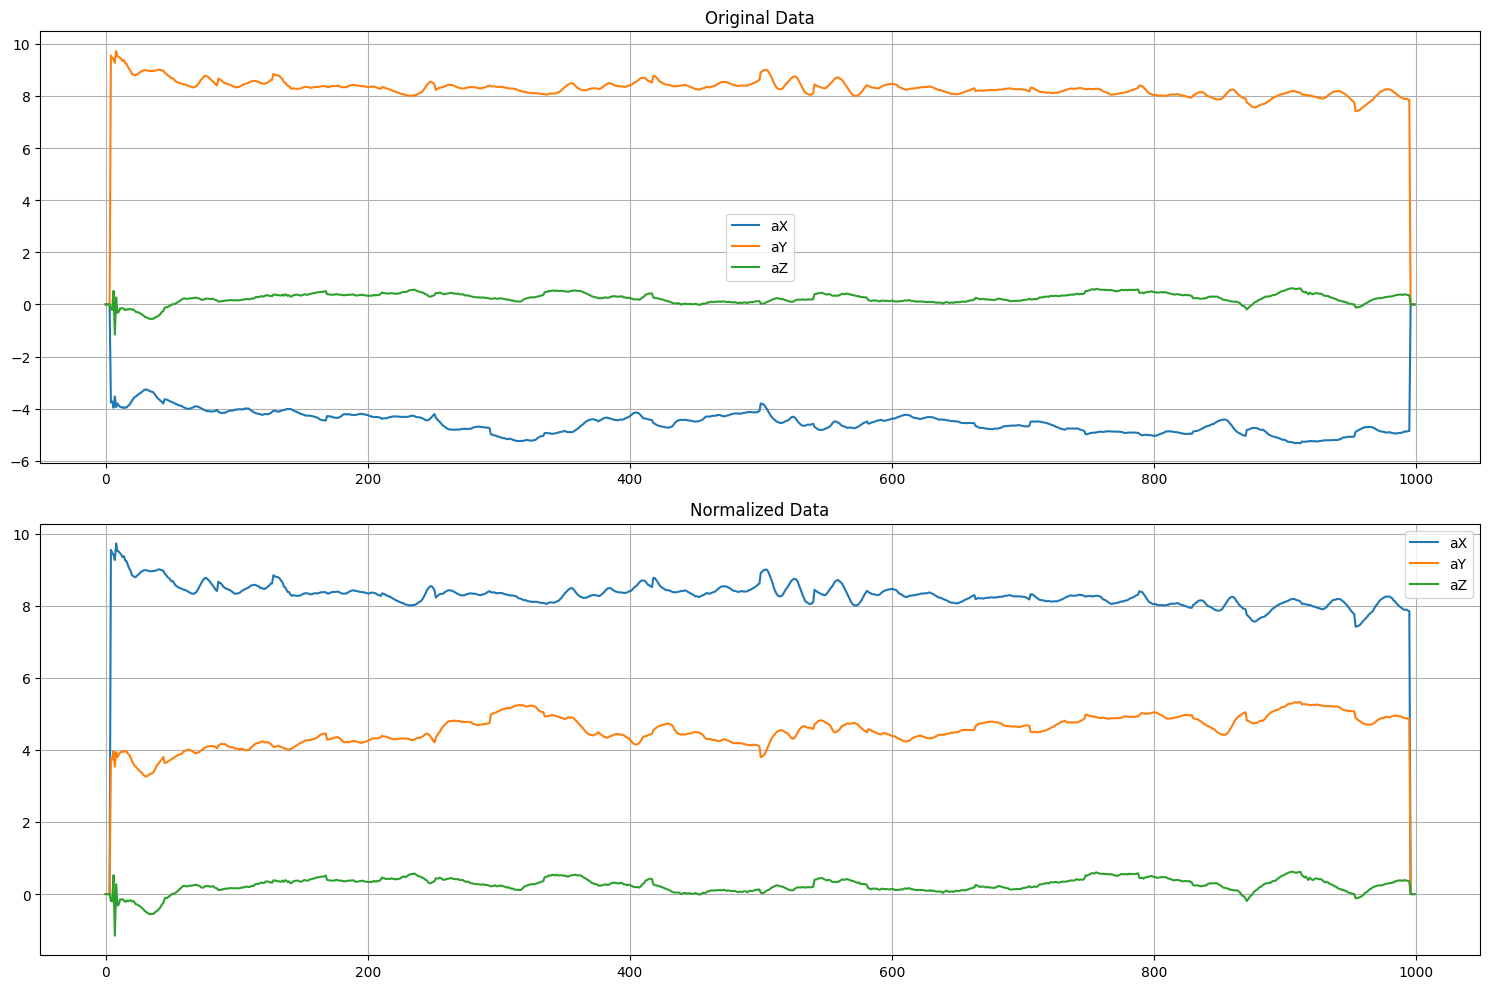


Sample 28 - Dumbbell Curl - Lift Instability


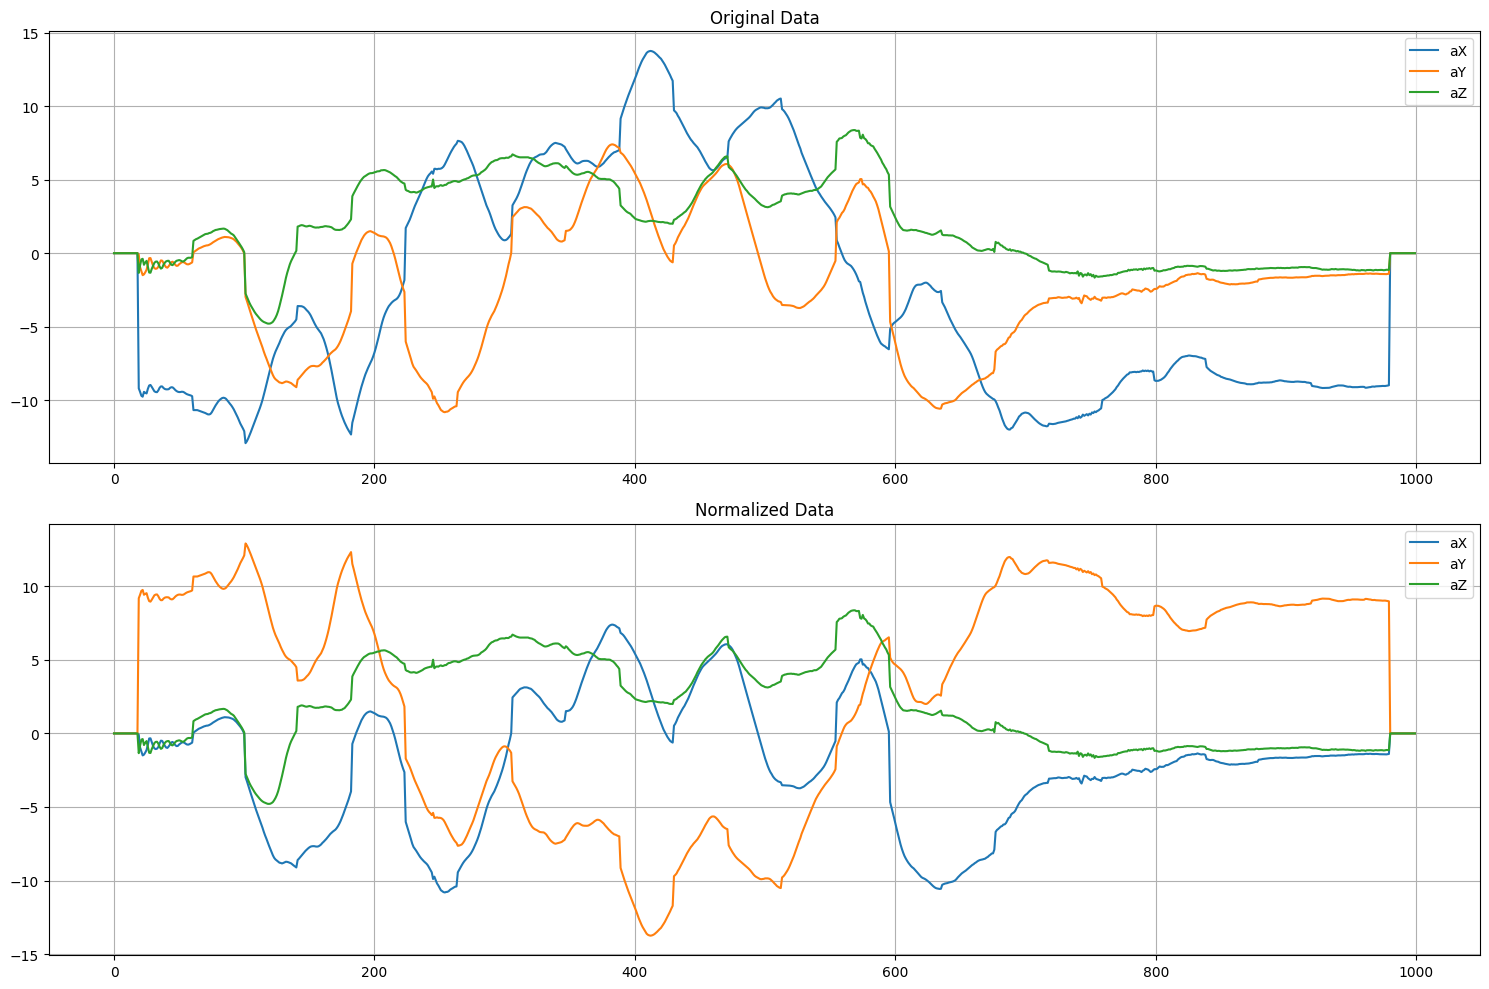


Sample 55 - Dumbbell Curl - Lift Instability


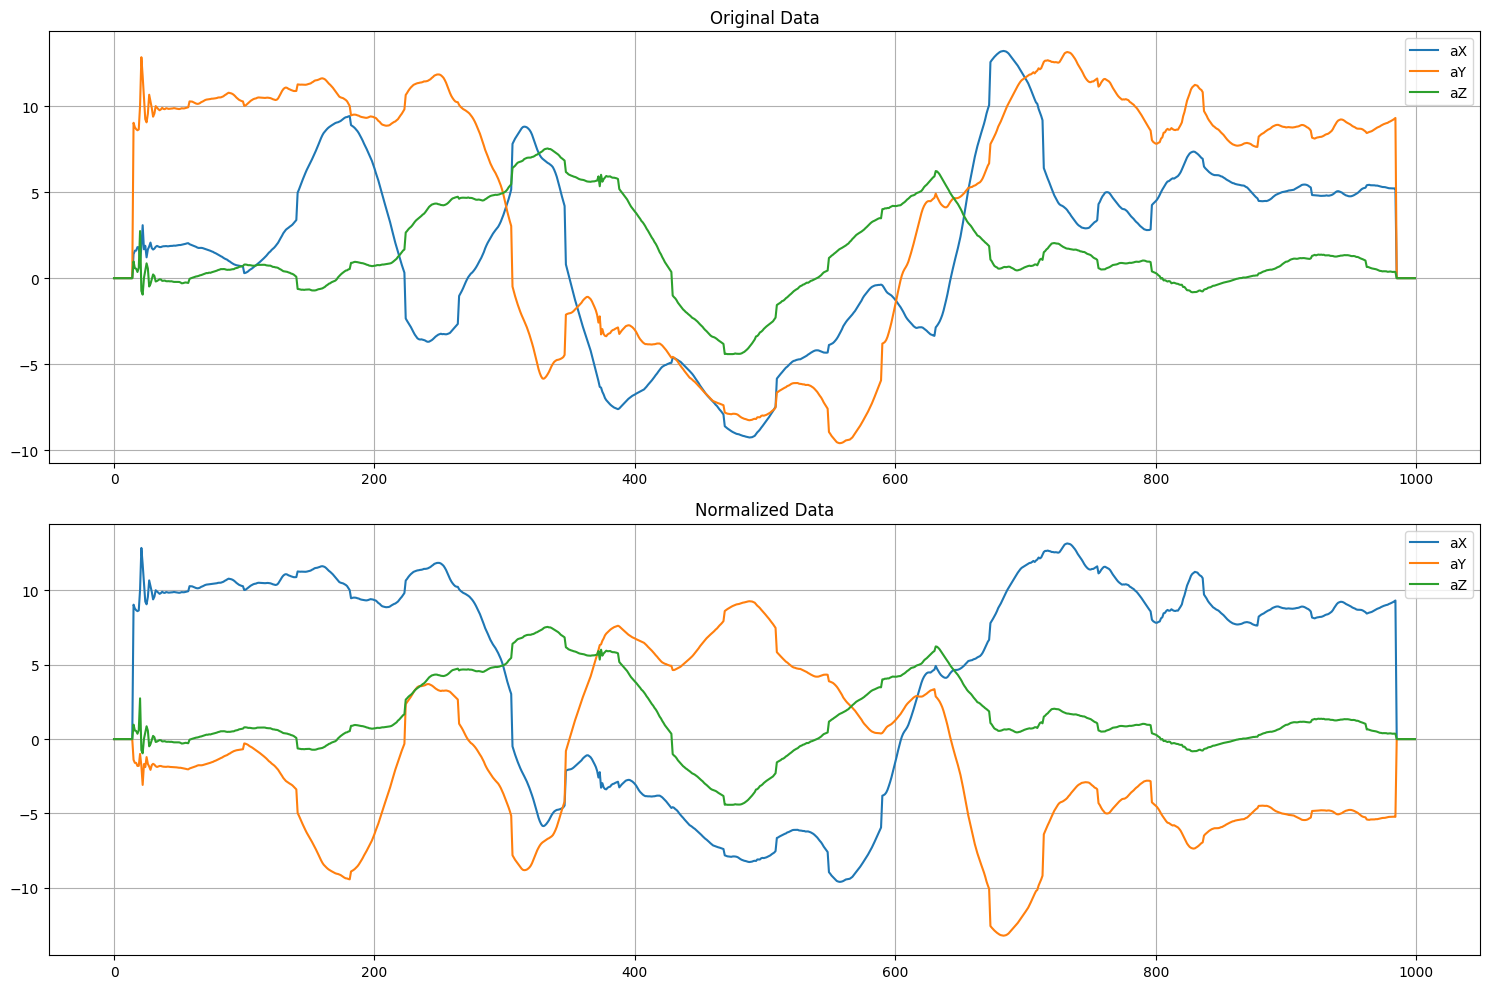


Sample 99 - Dumbbell Curl - Partial Motion


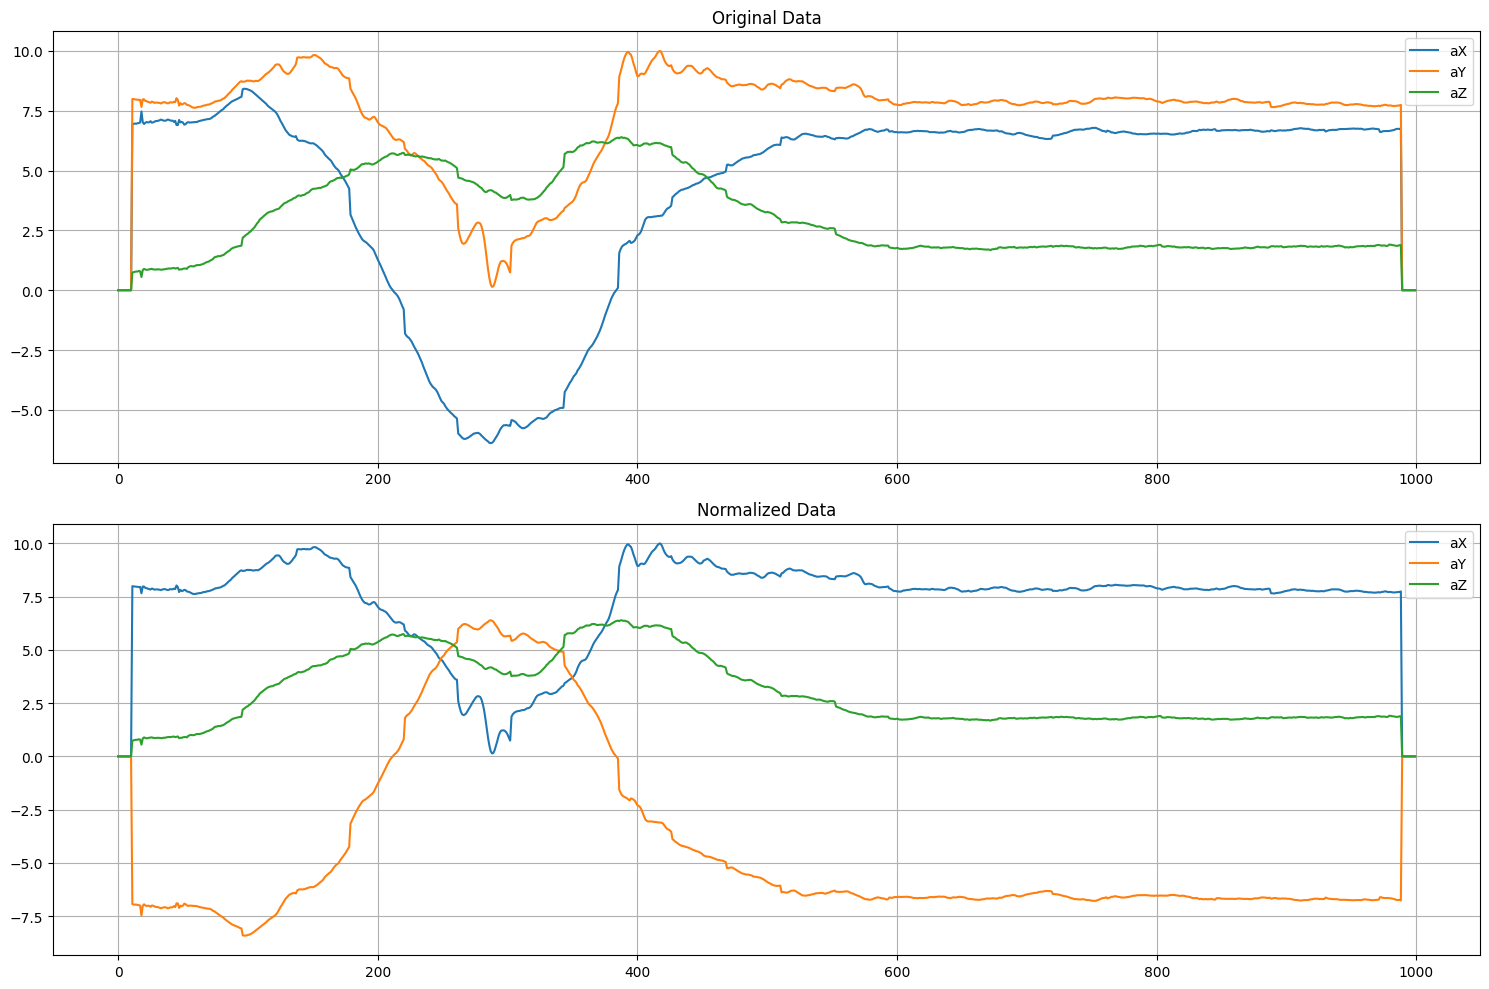


Sample 221 - Dumbbell Curl - No Lift


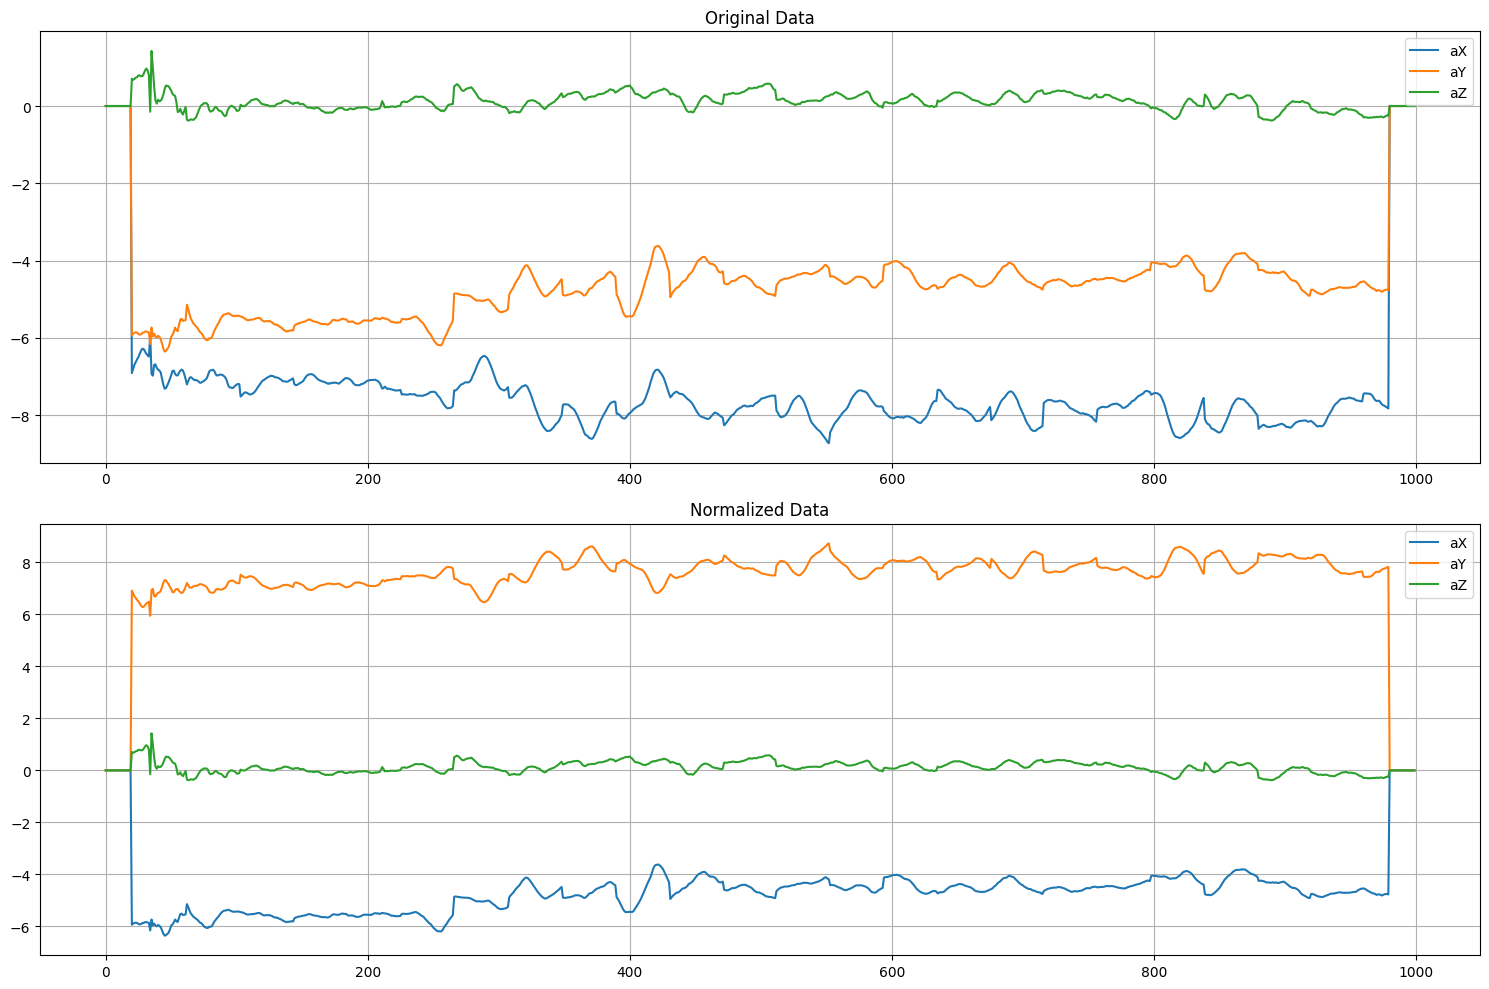


Sample 231 - Dumbbell Curl - No Lift


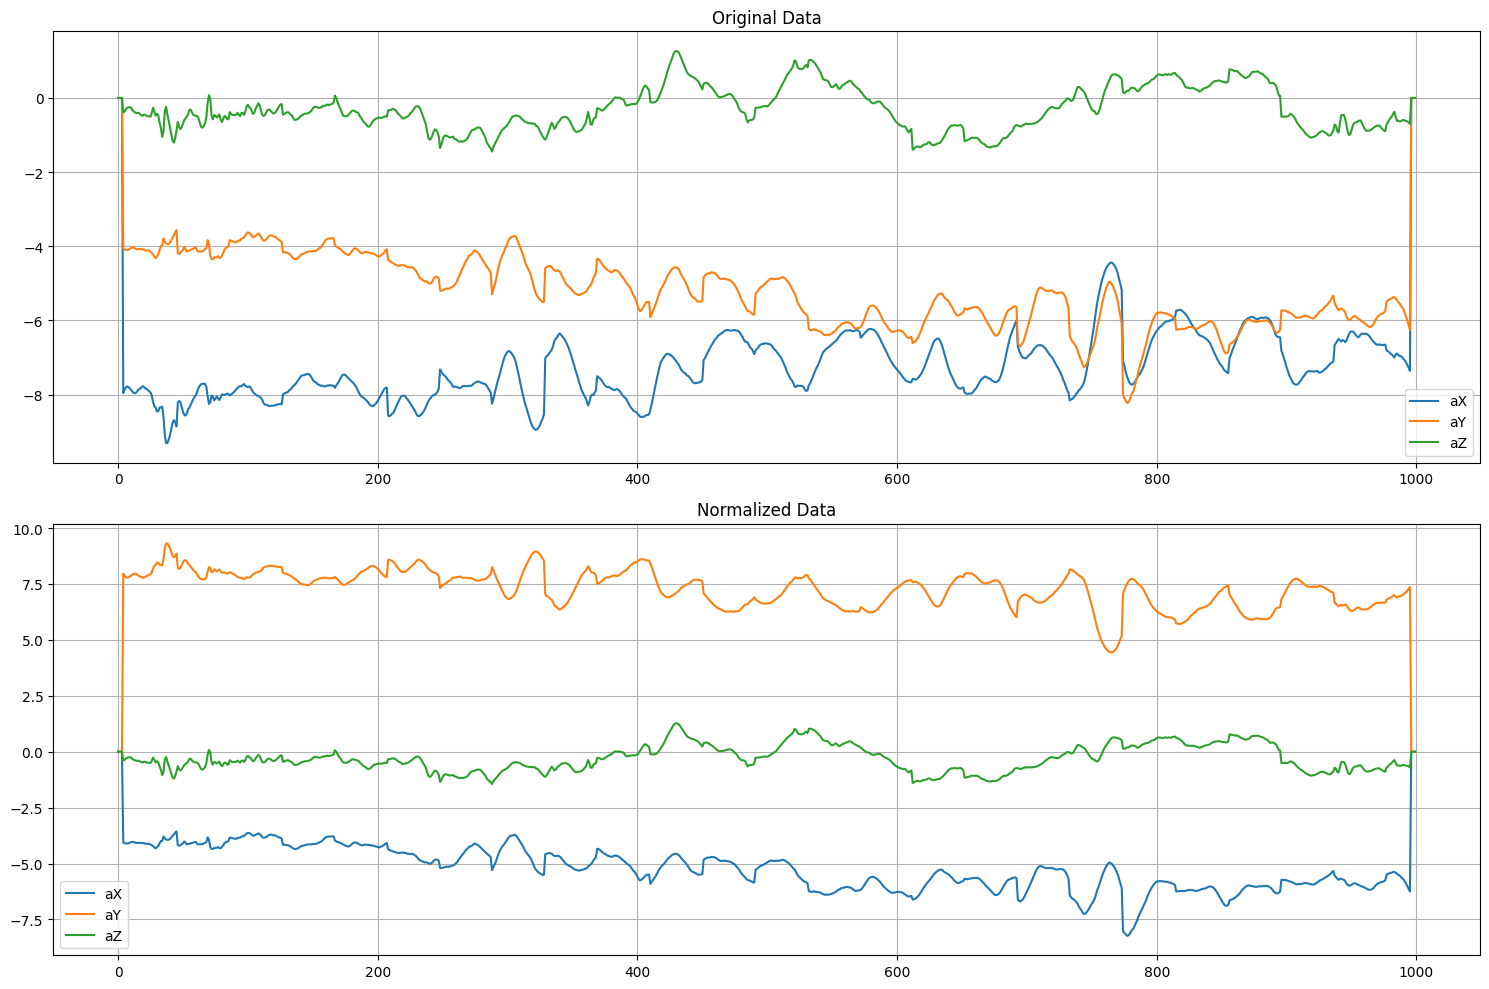

In [55]:
SHOW_NORMALIZATION = True
ROTATE_SIGNAL = True

if SHOW_NORMALIZATION:
    # Visualize normalization for a few samples
    for i in [16, 28, 55, 99, 221, 231]:  # Show rep sample
        print(
            f"\nSample {i} - {LIFT_NAMES[DATASET[i]['lN']]} - {LIFT_CLASSES[DATASET[i]['lC']]}"
        )
        label, original_data = convert_to_array(DATASET[i])
        extended_data = extend_dataset_length(original_data, 1000)
        downsampled_data = downsample_dataset(extended_data, VECTOR_Y, "avg")
        if ROTATE_SIGNAL:
            rotated_data = rotate_signal(extended_data, 90, 0)
            normalized_data = normalize_sensor_data(rotated_data, ACC_MIN, ACC_MAX)
            plot_normalization_comparison(extended_data, rotated_data)
        else:
            normalized_data = normalize_sensor_data(extended_data, ACC_MIN, ACC_MAX)
            plot_normalization_comparison(extended_data, normalized_data)


In [24]:
print("VALIDATION DATASET")
VALIDATION_X, VALIDATION_Y = preprocess_dataset(validation_dataset, augment=False)
print("--------------------------------")
print("TEST DATASET")
TEST_X, TEST_Y = preprocess_dataset(test_dataset, augment=True)
print("--------------------------------")
print("TRAIN DATASET")
TRAIN_X, TRAIN_Y = preprocess_dataset(train_dataset, augment=True)
print("--------------------------------")

print(f"Validation: {VALIDATION_X.shape} Labels: {VALIDATION_Y.shape})")
print(f"Test: {TEST_X.shape} Labels: {TEST_Y.shape})")
print(f"Train: {TRAIN_X.shape} Labels: {TRAIN_Y.shape})")

VALIDATION DATASET
Initial class distribution: {'s_w': 13, 'p_m': 11, 'l_i': 8, 'n_l': 12, 'p_f': 8, 'o_a': 7}
Class distribution after initial balancing:
{'s_w': 7, 'p_m': 7, 'l_i': 7, 'n_l': 7, 'p_f': 7, 'o_a': 7}
Applying 3 random rotations to each sample...

Final class distribution (after rotations): {'s_w': 28, 'p_m': 28, 'l_i': 28, 'n_l': 28, 'p_f': 28, 'o_a': 28}

Shape Checks:
X shape: (168, 200, 3)
y shape: (168,)
Number of unique labels: 6
--------------------------------
TEST DATASET
Initial class distribution: {'n_l': 2, 'o_a': 5, 's_w': 8, 'p_f': 5, 'l_i': 3, 'p_m': 6}
Class distribution after initial balancing:
{'n_l': 16, 'o_a': 16, 's_w': 16, 'p_f': 16, 'l_i': 16, 'p_m': 16}
Applying 3 random rotations to each sample...

Final class distribution (after rotations): {'n_l': 64, 'o_a': 64, 's_w': 64, 'p_f': 64, 'l_i': 64, 'p_m': 64}

Shape Checks:
X shape: (384, 200, 3)
y shape: (384,)
Number of unique labels: 6
--------------------------------
TRAIN DATASET
Initial class

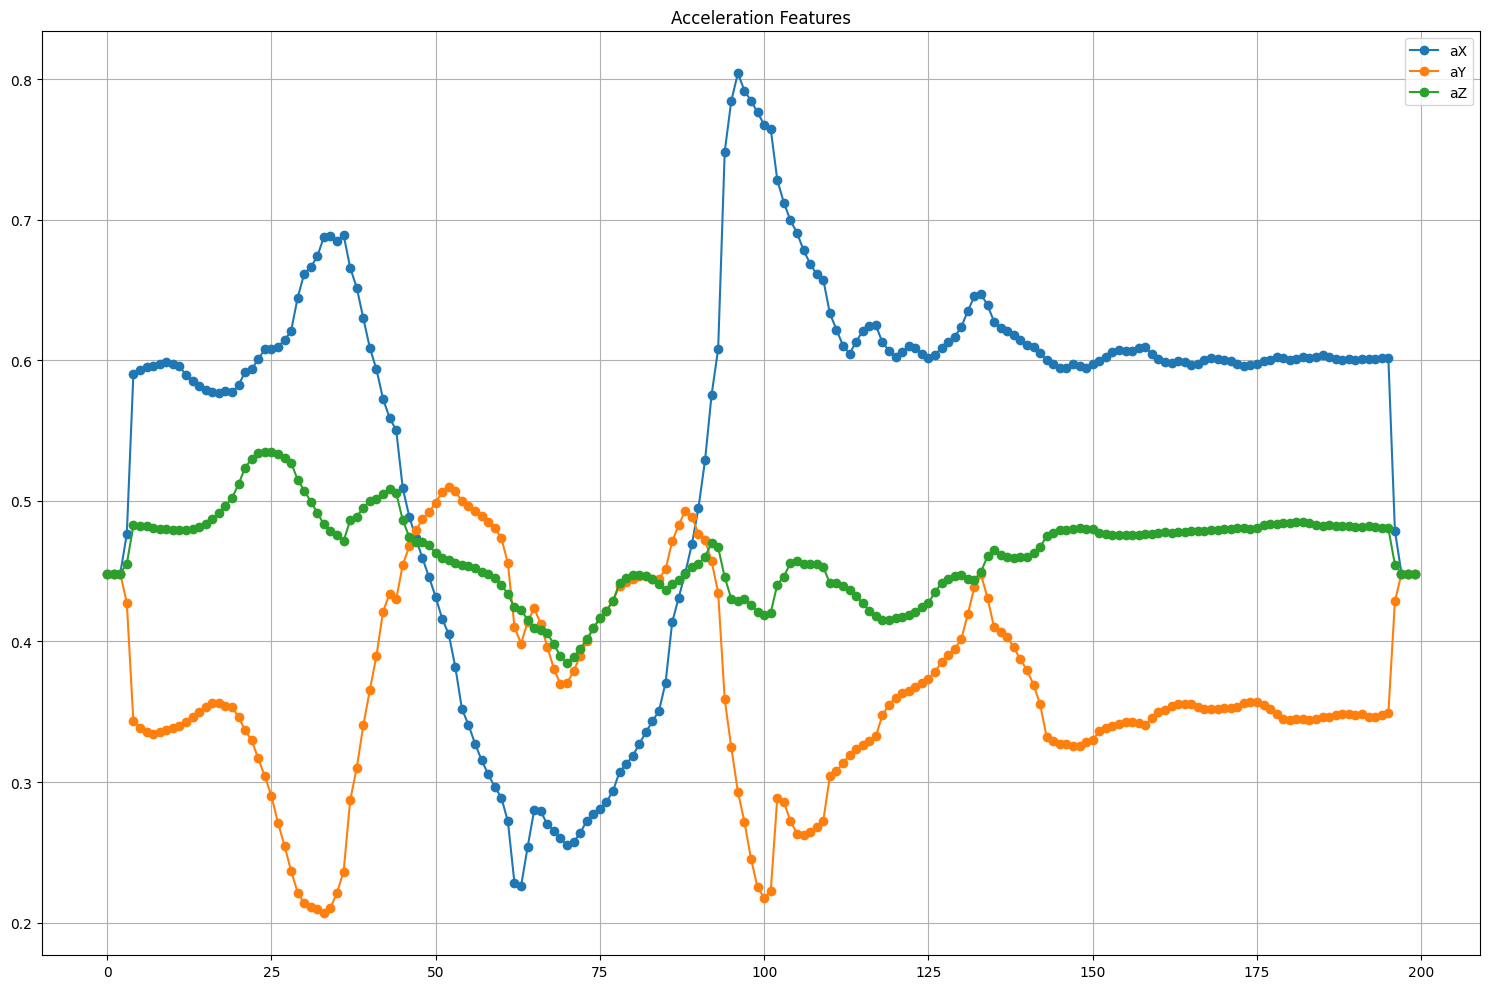

In [44]:
def plot_feature_distribution(data, labels, idx = 0):
    first_sample = data[idx] 
    first_label = labels[idx] 

    # Create a figure with one subplot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot values for acceleration features (0:3)
    ax.plot(first_sample[:, 0], marker="o", label="aX")
    ax.plot(first_sample[:, 1], marker="o", label="aY")
    ax.plot(first_sample[:, 2], marker="o", label="aZ")
    ax.set_title("Acceleration Features")
    ax.legend()
    ax.grid(True)

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

# Call the function gated by an if statement
SHOW_FEATURE_PLOT = True
if SHOW_FEATURE_PLOT:
    plot_feature_distribution(VALIDATION_X, VALIDATION_Y, idx = 3)

In [26]:
# Inference Label Output
labels = sorted(set(TEST_Y).union(set(VALIDATION_Y)).union(set(TRAIN_Y)))
labelToInt = {}
currInt = 0
for label in labels:
    labelToInt[label] = currInt
    currInt = currInt + 1
intToLabel = {v: k for k, v in labelToInt.items()}
print(intToLabel)

{0: 'l_i', 1: 'n_l', 2: 'o_a', 3: 'p_f', 4: 'p_m', 5: 's_w'}


In [27]:
intToLabel.values()

dict_values(['l_i', 'n_l', 'o_a', 'p_f', 'p_m', 's_w'])

In [28]:
# One Hot Encoding of Labels
TEST_Y_cat = tf.keras.utils.to_categorical([labelToInt[y] for y in TEST_Y])
VALIDATION_Y_cat = tf.keras.utils.to_categorical([labelToInt[y] for y in VALIDATION_Y])
TRAIN_Y_cat = tf.keras.utils.to_categorical([labelToInt[y] for y in TRAIN_Y])

# Define Batch Size
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 256
AUTO = tf.data.AUTOTUNE

# Create tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((TRAIN_X, TRAIN_Y_cat))
val_ds = tf.data.Dataset.from_tensor_slices((VALIDATION_X, VALIDATION_Y_cat))
test_ds = tf.data.Dataset.from_tensor_slices((TEST_X, TEST_Y_cat))

train_ds = (
    train_ds.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)
)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(AUTO)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(AUTO)


for x, y in train_ds.take(1):
    print(x.shape, y.shape)

# The OUT_OF_RANGE error is OKAY.

(64, 200, 3) (64, 6)


2024-12-07 12:23:08.902054: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-07 12:23:08.902478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model Definition


In [29]:
INPUT_SHAPE = (VECTOR_Y, VECTOR_X)

dropout_rate = 0.25

def create_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv1D(32, kernel_size=7, padding="same")(inputs)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same")(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate * 1.2)(x)

    # x = tf.keras.layers.Conv1D(64, kernel_size=3, padding="same")(x)
    # x = tf.keras.layers.ReLU()(x)
    # x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(dropout_rate * 1.5)(x)

    x = tf.keras.layers.Conv1D(64, kernel_size=3, padding="same")(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate * 1.7)(x)

    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate * 2)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)


model = create_model()

In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 32)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,182 (117.90 KB)

 Trainable params: 29,990 (117.15 KB)

 Non-trainable params: 192 (768.00 B)

In [31]:
%load_ext tensorboard

In [32]:
# Calculate steps per epoch
steps_per_epoch = len(train_ds)

# Define learning rate parameters
initial_learning_rate = 0.001
warmup_epochs = 50
warmup_steps = warmup_epochs * steps_per_epoch
first_decay_epochs = 250
first_decay_steps = first_decay_epochs * steps_per_epoch

# Cosine Decay with Warmup schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps=first_decay_steps,
    t_mul=2,  # Each restart cycle will be 1.5x longer than the previous
    m_mul=0.98,  # Each restart will have 0.95x the max learning rate of the previous
    alpha=0.2,  # Minimum learning rate will be 10% of initial
)

# Update optimizer with new schedule
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ["accuracy"]

EPOCHS = 5000  # MAKE SURE THAT THE VAL_THRESHOLD IS MET

checkpoint_filepath = os.path.join(CHKPT_DIR, "cp-{epoch:04d}.keras")
os.makedirs(CHKPT_DIR, exist_ok=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

val_threshold = 0.97


class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("val_accuracy") > val_threshold:
            print(f"\nReached {val_threshold} accuracy, stopping training!")
            self.model.stop_training = True


early_stopping_callback = EarlyStopping()

log_dir = os.path.join(LOG_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [33]:
%tensorboard --logdir={log_dir}

In [34]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_callback, tensorboard_callback, early_stopping_callback],
)

Epoch 1/5000


2024-12-07 12:23:13.941409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.1929 - loss: 1.8907 - val_accuracy: 0.1488 - val_loss: 1.7928
Epoch 2/5000
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.1966 - loss: 1.7813 - val_accuracy: 0.1667 - val_loss: 1.7929
Epoch 3/5000
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.2083 - loss: 1.7774 - val_accuracy: 0.1845 - val_loss: 1.7924
Epoch 4/5000
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.2046 - loss: 1.7778 - val_accuracy: 0.1667 - val_loss: 1.7919
Epoch 5/5000
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.2130 - loss: 1.7681 - val_accuracy: 0.1607 - val_loss: 1.7910
Epoch 6/5000
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2239 - loss: 1.7650 - val_accuracy: 0.1548 - val_loss: 1.7901
Epoch 7/5000
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.2025 - loss: 1.7735 - val_accuracy: 0.1964 - val_loss: 1.7879
Epoch 8/5000
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.2195 - loss: 1.7603 - val_accuracy: 0.1786 

KeyboardInterrupt: 

In [ ]:
# Export the model
model.export(f"{SAVED_MODEL_FILENAME}")


## Quantization

In [ ]:
# Save a non quantized model
converter = tf.lite.TFLiteConverter.from_saved_model(f"{SAVED_MODEL_FILENAME}")
model_no_quant_tflite = converter.convert()

with open(FLOAT_TFL_MODEL_FILENAME, "wb") as f:
    f.write(model_no_quant_tflite)

In [ ]:
def representative_dataset():
    for data in train_ds.take(100):
        yield [tf.cast(data[0], tf.float32).numpy()]


converter = tf.lite.TFLiteConverter.from_saved_model(f"{SAVED_MODEL_FILENAME}")

# Basic optimization settings
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Force full INT8 quantization
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    tf.lite.OpsSet.TFLITE_BUILTINS,
]

# Representative dataset is required for full integer quantization
converter.representative_dataset = representative_dataset

# Force input/output to be INT8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Enable full integer quantization
converter.full_integer_quantization = True

# Metal-specific settings
converter._experimental_disable_per_channel = True
converter.experimental_new_quantizer = False  # Changed to False for Metal
converter.target_spec.supported_types = [tf.int8]
converter.allow_custom_ops = False

# Convert model
model_tflite = converter.convert()

with open(QUANTIZED_TFL_MODEL_FILENAME, "wb") as f:
    f.write(model_tflite)

In [ ]:
# Compare model sizes
def get_dir_size(dir_path):
    total_size = 0
    for dirpath, _, filenames in os.walk(dir_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size


# Calculate sizes
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

# Create comparison DataFrame
size_comparison = pd.DataFrame(
    {
        "Model": ["TensorFlow", "TensorFlow Lite", "TensorFlow Lite Quantized"],
        "Size": [
            f"{size_tf:,} bytes",
            f"{size_no_quant_tflite:,} bytes",
            f"{size_tflite:,} bytes",
        ],
        "Reduction": [
            "",
            f"(reduced by {size_tf - size_no_quant_tflite:,} bytes)",
            f"(reduced by {size_no_quant_tflite - size_tflite:,} bytes)",
        ],
    }
).set_index("Model")

# Display comparison
size_comparison

In [ ]:
def check_tflite_model(tflite_model_path):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print("== Input Details ==")
    for detail in input_details:
        print(f"Name: {detail['name']}")
        print(f"Shape: {detail['shape']}")
        print(f"Type: {detail['dtype']}")
        print(f"Quantization: {detail['quantization']}")
        print()

    print("== Output Details ==")
    for detail in output_details:
        print(f"Name: {detail['name']}")
        print(f"Shape: {detail['shape']}")
        print(f"Type: {detail['dtype']}")
        print(f"Quantization: {detail['quantization']}")
        print()

    # Print model size
    print(f"Model Size: {os.path.getsize(tflite_model_path) / 1024:.2f} KB")


# Check both models
print("=== Float Model ===")
check_tflite_model(FLOAT_TFL_MODEL_FILENAME)
print("\n=== Quantized Model ===")
check_tflite_model(QUANTIZED_TFL_MODEL_FILENAME)

## Test Models

In [ ]:
def evaluate_models():

    def run_tflite_inference(interpreter, input_data, is_quantized=False, debug=False):
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Debug: Print input details
        if debug:
            print(f"Input details: {input_details}")
            print(f"Output details: {output_details}")

        input_data = input_data.numpy()

        # Handle input scaling for quantized model
        if is_quantized:
            input_scale = input_details[0]["quantization"][0]
            input_zero_point = input_details[0]["quantization"][1]
            input_data = input_data / input_scale + input_zero_point
            input_data = input_data.astype(np.int8)
        else:
            input_data = input_data.astype(np.float32)

        predictions = []
        input_data_reshaped = input_data.reshape(
            (-1,) + tuple(input_details[0]["shape"][1:])
        )

        # Process batches
        for i in range(input_data_reshaped.shape[0]):
            sample = input_data_reshaped[i : i + 1]
            interpreter.set_tensor(input_details[0]["index"], sample)
            interpreter.invoke()
            output = interpreter.get_tensor(output_details[0]["index"])

            # Dequantize output if needed
            if is_quantized:
                output_scale = output_details[0]["quantization"][0]
                output_zero_point = output_details[0]["quantization"][1]
                output = (output.astype(np.float32) - output_zero_point) * output_scale

            predictions.append(output[0])

        return np.array(predictions)

    def calculate_metrics(y_true, y_pred, class_names):
        """
        Calculates classification metrics with proper handling of class names.
        Args:
            y_true: True labels
            y_pred: Predicted labels
            class_names: Dictionary mapping class indices to names
        Returns:
            Tuple of (accuracy, precision, recall, f1)
        """
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="weighted", labels=list(class_names.keys())
        )
        return accuracy, precision, recall, f1

    # Initialize results dictionary
    results = {}
    y_true = np.argmax(TEST_Y_cat, axis=1)

    # Test each model variant
    models_to_test = [
        ("TensorFlow", None, False, True),
        ("TFLite Float", FLOAT_TFL_MODEL_FILENAME, False, True),
        ("TFLite Quantized", QUANTIZED_TFL_MODEL_FILENAME, True, True),
    ]

    for model_name, model_path, is_quantized, debug in models_to_test:
        print(f"\nTesting {model_name}...")

        if model_name == "TensorFlow":
            # Handle TensorFlow model
            predictions = []
            for x, _ in test_ds:
                pred = model.predict(x, verbose=0)
                predictions.extend(pred)
        else:
            # Handle TFLite models
            interpreter = tf.lite.Interpreter(model_path=model_path)
            interpreter.allocate_tensors()
            input_details = interpreter.get_input_details()
            print("Quantization parameters:", input_details[0]["quantization"])

            predictions = []
            for x, _ in test_ds:
                pred_batch = run_tflite_inference(interpreter, x, is_quantized, debug)
                predictions.extend(pred_batch)

        predictions = np.array(predictions)
        pred_classes = np.argmax(predictions, axis=1)
        metrics = calculate_metrics(y_true, pred_classes, intToLabel)

        # Store results
        results[model_name] = {
            "accuracy": metrics[0],
            "precision": metrics[1],
            "recall": metrics[2],
            "f1": metrics[3],
        }

        # Print class distribution
        print(f"\n{model_name} Prediction Distribution:")
        unique, counts = np.unique(pred_classes, return_counts=True)
        for class_idx, count in zip(unique, counts):
            class_name = intToLabel.get(class_idx, f"Unknown ({class_idx})")
            print(f"{class_name}: {count} predictions")

    # Create comparison DataFrame
    return pd.DataFrame(
        {
            "Model": list(results.keys()),
            "Accuracy": [f"{results[model]['accuracy']*100:.2f}%" for model in results],
            "Precision": [
                f"{results[model]['precision']*100:.2f}%" for model in results
            ],
            "Recall": [f"{results[model]['recall']*100:.2f}%" for model in results],
            "F1 Score": [f"{results[model]['f1']*100:.2f}%" for model in results],
        }
    ).set_index("Model")


model_comparison = evaluate_models()
model_comparison

## Generate TFLite Model

In [41]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}

REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i '' 's/'{REPLACE_TEXT}'/g_rep_mate_model_data/g' {TFL_CC_MODEL_FILENAME}

In [ ]:
!cat {TFL_CC_MODEL_FILENAME}

In [ ]:
!tail {TFL_CC_MODEL_FILENAME}
